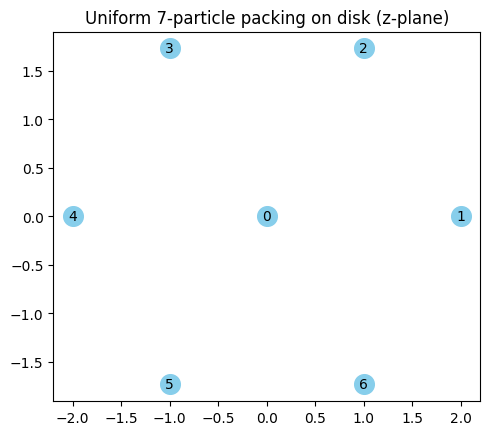

In [4]:
import numpy as np

def generate_uniform_disk_7(radius=2.0, height=5.4728, axis='z'):
    coords = []
    
    # 중심에 1개
    center = np.array([0.0, 0.0])
    coords.append(center)
    
    # 외곽 6개: 정육각형 대칭
    for i in range(6):
        angle = 2 * np.pi * i / 6
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        coords.append(np.array([x, y]))
    
    coords = np.array(coords)
    
    # 3D 변환
    final = []
    for x, y in coords:
        if axis == 'z':
            final.append([x, y, height])
        elif axis == '-z':
            final.append([x, y, -height])
        elif axis == 'x':
            final.append([height, x, y])
        elif axis == '-x':
            final.append([-height, x, y])
        elif axis == 'y':
            final.append([x, height, y])
        elif axis == '-y':
            final.append([x, -height, y])
    return np.array(final)
import matplotlib.pyplot as plt

coords = generate_uniform_disk_7(radius=2.0)
plt.scatter(coords[:, 0], coords[:, 1], s=200, c='skyblue')
for i, (x, y, _) in enumerate(coords):
    plt.text(x, y, str(i), ha='center', va='center')
plt.gca().set_aspect('equal')
plt.title("Uniform 7-particle packing on disk (z-plane)")
plt.show()


## 알고리즘: Concentric Ring Layering
n개의 점을 타원 내부에 배치하되, 그 중 가장 가까운 두 점 사이의 거리를 최대화하라
### 실용적 구현 (방법 1): 물리 기반 repulsion + ellipse constraint

In [18]:
import numpy as np
import os

def pack_points_in_ellipse(n, ry, rz, steps=500, lr=0.01):
    points = []
    while len(points) < n:
        y, z = np.random.uniform(-1, 1, size=2)
        if y**2 + z**2 <= 1.0:
            points.append([y, z])
    points = np.array(points)

    for _ in range(steps):
        grad = np.zeros_like(points)
        for i in range(n):
            for j in range(n):
                if i == j: continue
                diff = points[i] - points[j]
                dist = np.linalg.norm(diff) + 1e-6
                grad[i] += diff / dist**3
        points += lr * grad
        for i in range(n):
            y, z = points[i]
            norm = (y**2 + z**2)
            if norm > 1.0:
                points[i] /= np.sqrt(norm)
    return points[:, 0] * ry, points[:, 1] * rz

def place_on_plane(yz_coords, axis, offset, a, b, c):
    points = []
    for y, z in yz_coords:
        if axis == 'x':
            points.append([offset * a, y, z])
        elif axis == 'y':
            points.append([y, offset * b, z])
        elif axis == 'z':
            points.append([y, z, offset * c])
    return np.array(points)

def write_xyz(filename, water_coords, center_path="../../rotated_00_Alanine_zwitterion.xyz"):
    with open(center_path) as f:
        lines = f.readlines()
    n_center = int(lines[0])
    center_atoms = lines[2:2 + n_center]

    with open(filename, 'w') as f:
        f.write(f"{n_center + len(water_coords)}\n")
        f.write("Alanine + maximally spaced waters in ellipsoid face\n")
        f.writelines(center_atoms)
        for x, y, z in water_coords:
            f.write(f"O {x:.4f} {y:.4f} {z:.4f}\n")

def generate_all_xyz(n=10, output_dir="reference_xyz"):
    os.makedirs(output_dir, exist_ok=True)
    a, b, c = 3.2546, 3.8104, 5.4728
    axes = ['x', 'y', 'z']
    for axis in axes:
        ry = {'x': b, 'y': a, 'z': a}[axis]
        rz = {'x': c, 'y': c, 'z': b}[axis]
        for sign in [+1, -1]:
            y_coords, z_coords = pack_points_in_ellipse(n=n, ry=ry, rz=rz, steps=1000, lr=0.02)
            coords2d = np.stack([y_coords, z_coords], axis=1)
            coords3d = place_on_plane(coords2d, axis, sign, a, b, c)
            label = f"{'+' if sign > 0 else '-'}{axis}"
            outpath = os.path.join(output_dir, f"reference_{label}.xyz")
            write_xyz(outpath, coords3d)

generate_all_xyz(n=7)



## RMSD

In [ ]:
import os
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import procrustes
import shutil
import pandas as pd

# 설정
ref_dir = "./reference_xyz/"
case_dir = "../"
output_dir = "./clustered_cases/"
n_clusters = 10

# 1. 함수 정의
def load_O_coords_from_xyz(path, start_line=15):
    with open(path, 'r') as f:
        lines = f.readlines()[start_line:]
    coords = [list(map(float, line.strip().split()[1:4])) for line in lines if line.strip().startswith('O')]
    return np.array(coords)

def rmsd(a, b):
    if a.shape != b.shape or len(a.shape) != 2:
        raise ValueError(f"Shape mismatch for RMSD: {a.shape} vs {b.shape}")
    mtx1, mtx2, _ = procrustes(a, b)
    return np.sqrt(np.mean((mtx1 - mtx2) ** 2))

# 2. 참조 구조 로드
print("📌 Loading reference structures...")
reference_paths = sorted([os.path.join(ref_dir, f) for f in os.listdir(ref_dir) if f.endswith('.xyz')])
reference_structures = []
for path in reference_paths:
    coords = load_O_coords_from_xyz(path)
    print(f"  Loaded {path} with shape {coords.shape}")
    reference_structures.append(coords)

# 3. 케이스 구조 로드
print("\n📌 Loading case structures...")
case_paths = sorted([os.path.join(case_dir, f) for f in os.listdir(case_dir)
                     if not os.path.isdir(os.path.join(case_dir, f)) and "ref" not in f and f.endswith('.xyz')])
case_names = [os.path.basename(p) for p in case_paths]
case_coords_list = []
for path in case_paths:
    coords = load_O_coords_from_xyz(path)
    print(f"  Loaded {path} with shape {coords.shape}")
    case_coords_list.append(coords)

# 4. RMSD 벡터 생성
print("\n📌 Computing RMSD vectors...")
rmsd_vectors = []
for i, coords in enumerate(case_coords_list):
    vec = []
    for j, ref in enumerate(reference_structures):
        try:
            val = rmsd(coords, ref)
            print(f"    ✓ RMSD case {i} vs ref {j}: {val:.4f}")
            vec.append(val)
        except ValueError as e:
            print(f"    ✗ RMSD case {i} vs ref {j} failed: {e}")
            vec.append(np.nan)
    rmsd_vectors.append(vec)
rmsd_vectors = np.array(rmsd_vectors)

# 5. 결측치 제거 및 클러스터링
print("\n📌 Performing KMeans clustering...")
valid_idx = ~np.isnan(rmsd_vectors).any(axis=1)
filtered_rmsd_vectors = rmsd_vectors[valid_idx]
filtered_case_paths = [p for i, p in enumerate(case_paths) if valid_idx[i]]
filtered_case_names = [n for i, n in enumerate(case_names) if valid_idx[i]]

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(filtered_rmsd_vectors)

# 6. 그룹별 폴더 생성 및 파일 복사
print("\n📌 Organizing files into cluster folders...")
for i in range(n_clusters):
    cluster_folder = os.path.join(output_dir, f"cluster_{i}")
    os.makedirs(cluster_folder, exist_ok=True)

for label, case_path in zip(labels, filtered_case_paths):
    shutil.copy(case_path, os.path.join(output_dir, f"cluster_{label}", os.path.basename(case_path)))
    print(f"  → Copied {os.path.basename(case_path)} to cluster_{label}")



📌 Loading reference structures...
  Loaded ./reference_xyz/reference_+x.xyz with shape (7, 3)
  Loaded ./reference_xyz/reference_+y.xyz with shape (7, 3)
  Loaded ./reference_xyz/reference_+z.xyz with shape (7, 3)
  Loaded ./reference_xyz/reference_-x.xyz with shape (7, 3)
  Loaded ./reference_xyz/reference_-y.xyz with shape (7, 3)
  Loaded ./reference_xyz/reference_-z.xyz with shape (7, 3)

📌 Loading case structures...
  Loaded ../case_001.xyz with shape (7, 3)
  Loaded ../case_002.xyz with shape (7, 3)
  Loaded ../case_003.xyz with shape (7, 3)
  Loaded ../case_004.xyz with shape (7, 3)
  Loaded ../case_007.xyz with shape (7, 3)
  Loaded ../case_008.xyz with shape (7, 3)
  Loaded ../case_009.xyz with shape (7, 3)
  Loaded ../case_010.xyz with shape (7, 3)
  Loaded ../case_011.xyz with shape (7, 3)
  Loaded ../case_012.xyz with shape (7, 3)
  Loaded ../case_014.xyz with shape (7, 3)
  Loaded ../case_016.xyz with shape (7, 3)
  Loaded ../case_019.xyz with shape (7, 3)
  Loaded ../case_

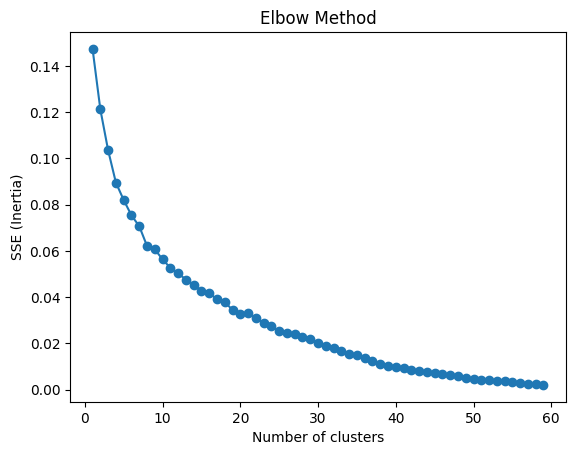

In [45]:
import matplotlib.pyplot as plt

sse = []
K_range = range(1, 60)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(filtered_rmsd_vectors)
    sse.append(km.inertia_)

plt.plot(K_range, sse, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method')
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score
# 클러스터링이 얼마나 잘 되었는지를 -1 ~ 1 사이로 평가 (1에 가까울수록 좋음)
score = silhouette_score(filtered_rmsd_vectors, labels)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.1383


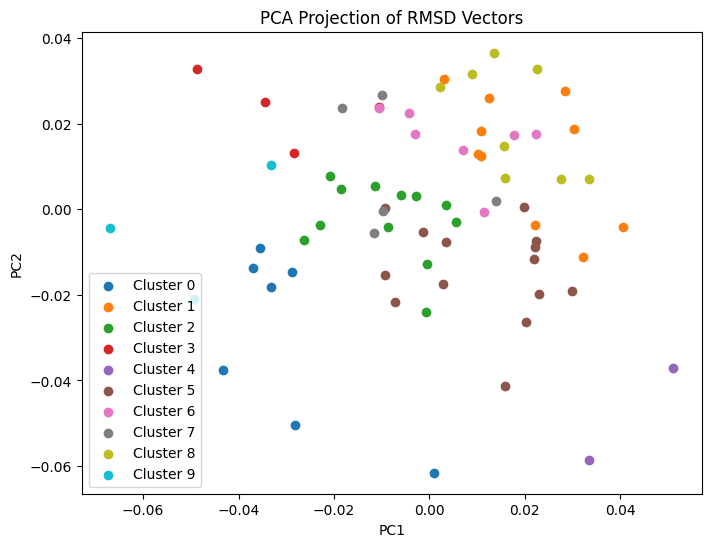

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
proj = pca.fit_transform(filtered_rmsd_vectors)

plt.figure(figsize=(8,6))
for i in range(n_clusters):
    idx = labels == i
    plt.scatter(proj[idx, 0], proj[idx, 1], label=f"Cluster {i}")
plt.legend()
plt.title("PCA Projection of RMSD Vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


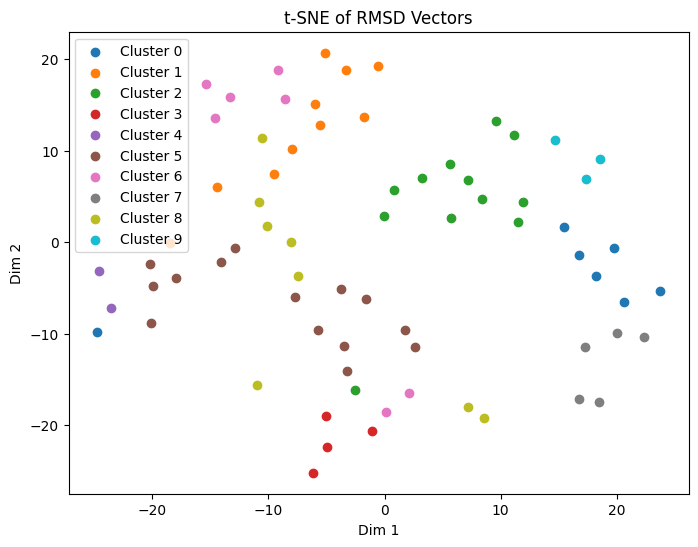

In [48]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
proj = tsne.fit_transform(filtered_rmsd_vectors)

plt.figure(figsize=(8,6))
for i in range(n_clusters):
    idx = labels == i
    plt.scatter(proj[idx, 0], proj[idx, 1], label=f"Cluster {i}")
plt.legend()
plt.title("t-SNE of RMSD Vectors")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()


In [49]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1.5, min_samples=5)  # eps는 거리 기준, 적절히 튜닝 필요
labels_db = db.fit_predict(filtered_rmsd_vectors)
n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
print(f"DBSCAN found {n_clusters_db} clusters (excluding noise)")


DBSCAN found 1 clusters (excluding noise)


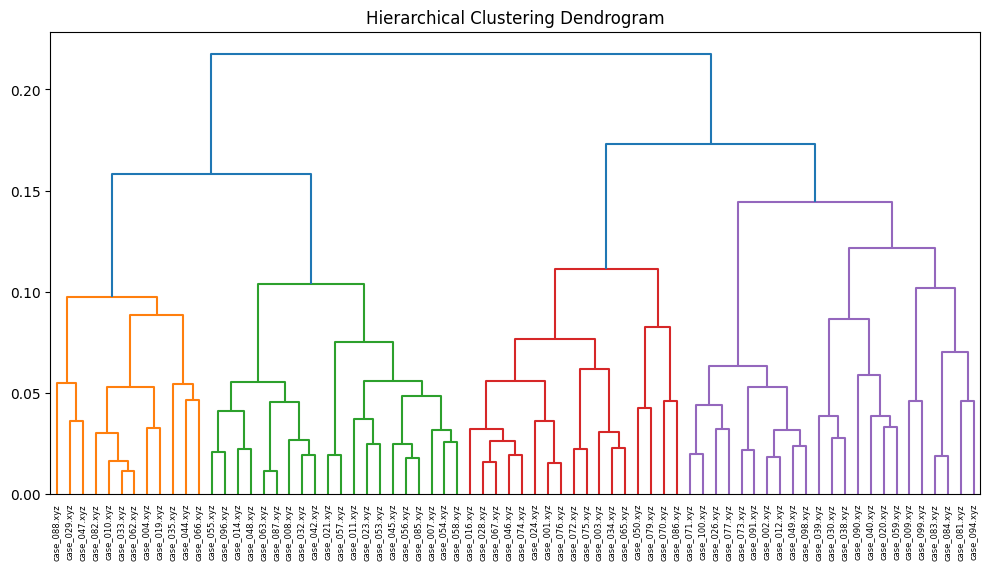

In [50]:
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(filtered_rmsd_vectors, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, labels=filtered_case_names, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


cases